Reference Links:<br>
https://fanpu.io/blog/2023/score-based-diffusion-models/<br>
https://mfkasim1.github.io/2022/07/01/sgm-1/

In [1]:
# 1 sample the training data from the swiss roll distribution.
# 2 From the training data, we will try to learn how to draw new samples from the swiss roll distribution with Score-based Generative Model (SGM)
# 3 without SDE

In [8]:
import torch
from sklearn.datasets import make_swiss_roll

# generate the swiss roll dataset
# generate 1000 samples and add Gaussion noise with a standard deviation of 1.0 to the data
xnp, _ = make_swiss_roll(1000, noise=0)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)
# creates a TensorDataset from the xtns tensor. This makes it easy batching and shuffling of the data.

In [9]:
len(xtns)

1000

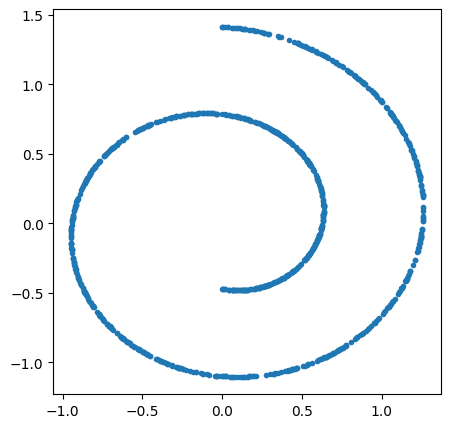

In [10]:
# show the samples
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

In [11]:
# score_network takes input of 2 dimension and returns the output of the same size

class NoiseConditionalScoreNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.LogSigmoid(),
            torch.nn.Linear(64, 64),
            torch.nn.LogSigmoid(),
            torch.nn.Linear(64, 64),
            torch.nn.LogSigmoid(),
            torch.nn.Linear(64, 2),
        )

    def forward(self, x, sigma):
        combined_input = torch.cat([x, sigma], dim=1)
        return self.net(combined_input)

# Usage
score_network = NoiseConditionalScoreNet()

In [13]:
import numpy as np
def max_euclidean_distance(data):
    max_distance = 0
    n = len(data)
    for i in range(n):
        for j in range(i+1, n):
            distance = np.linalg.norm(data[i] - data[j])
            max_distance = max(max_distance, distance)
    return max_distance
swiss_data = xnp[:, [0, 2]] / 10.0
max_distance = max_euclidean_distance(swiss_data)
max_distance

2.521186199561764

In [14]:
sigmas = torch.tensor(np.exp(np.linspace(np.log(max_distance), np.log(0.01), 10))).float()
sigmas

tensor([2.5212, 1.3638, 0.7378, 0.3991, 0.2159, 0.1168, 0.0632, 0.0342, 0.0185,
        0.0100])

Loss function:
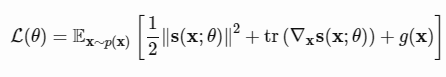

In [15]:
# Imports jacrev and vmap from functorch. These will be used to compute jacobians.
from functorch import jacrev, vmap

# specify the return type of the function is torch.Tensor
def calc_loss(score_network, samples, labels, sigmas):
    total_loss = 0
    batch_size = samples.size(0)
    for sigma in sigmas:
      sigma_tensor = torch.full((batch_size, 1), sigma,)
      perturbed_samples = samples + torch.randn_like(samples) * sigma
      scores = score_network(perturbed_samples, sigma_tensor)

      l2_norm = torch.linalg.norm(sigma * scores + (perturbed_samples - samples) / sigma, dim=-1) ** 2
      total_loss += l2_norm
    total_loss = total_loss * 0.5 /10
    return total_loss.mean(dim=0)

In [16]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=True)
t0 = time.time()
for i_epoch in range(5000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()

        # training step
        labels = torch.randint(0, len(sigmas), (data.shape[0],))
        loss = calc_loss(score_network, data, labels, sigmas)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 500 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")

0 (0.651320219039917s): 1.0513271780014037
500 (130.1392719745636s): 0.7362465167045593
1000 (251.161372423172s): 0.7055225167274475
1500 (377.5051763057709s): 0.6793741569519043
2000 (527.4541144371033s): 0.6609216208457946
2500 (694.5583562850952s): 0.6610716090202332
3000 (865.7012670040131s): 0.6213947014808655
3500 (1039.7063748836517s): 0.583585364818573
4000 (1215.5191342830658s): 0.558506938457489
4500 (1390.734790802002s): 0.5647498359680175


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


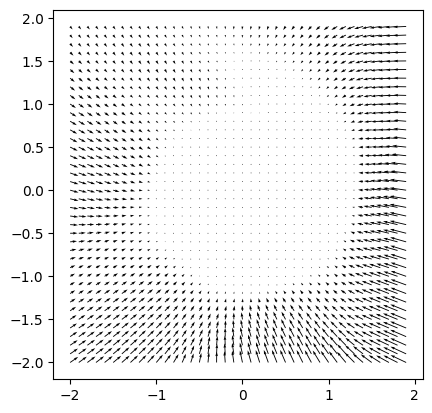

<Figure size 1500x1500 with 0 Axes>

In [17]:
# display the Score function (the vector field) in the 2D space
import matplotlib.pyplot as plt

# Generate grid of input points
res = 0.1
x = torch.arange(-2, 2, res)
y = torch.arange(-2, 2, res)
xx, yy = torch.meshgrid(x, y)
x_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Get score vectors on grid
sigma_tensor = torch.full((1600, 1), sigmas[-1],)
s_grid = score_network(x_grid, sigma_tensor).detach()

# Plot
fig, ax = plt.subplots()
ax.quiver(x_grid[:,0], x_grid[:,1], s_grid[:,0], s_grid[:,1])
ax.set_aspect('equal')
plt.figure(figsize=(15,15))
plt.show()

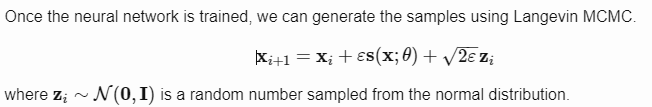

In [18]:
def generate_samples(score_net: torch.nn.Module, nsamples: int, eps: float = 0.00001, nsteps: int = 200) -> torch.Tensor:
    # generate samples using Langevin MCMC
    # x0: (sample_size, nch)
    saved_samples = []
    x0 = torch.rand((nsamples, 2)) * 2 - 1

    for sigma in sigmas:
      for i in range(nsteps):
        current_lr = eps * (sigma / sigmas[-1]) ** 2
        # print(current_lr)
        sigma_tensor = torch.full((x0.size(0), 1), sigma,)
        # print(sigma_tensor)
        x0 = x0 + current_lr * score_net(x0, sigma_tensor).detach() + np.sqrt(2*current_lr) * torch.randn_like(x0)
        # print(x0)
        # return
      saved_samples.append(x0.detach().clone())

    return saved_samples

In [19]:
# generate 1000 samples every 10 timesteps
saved_samples = generate_samples(score_network, 1000)

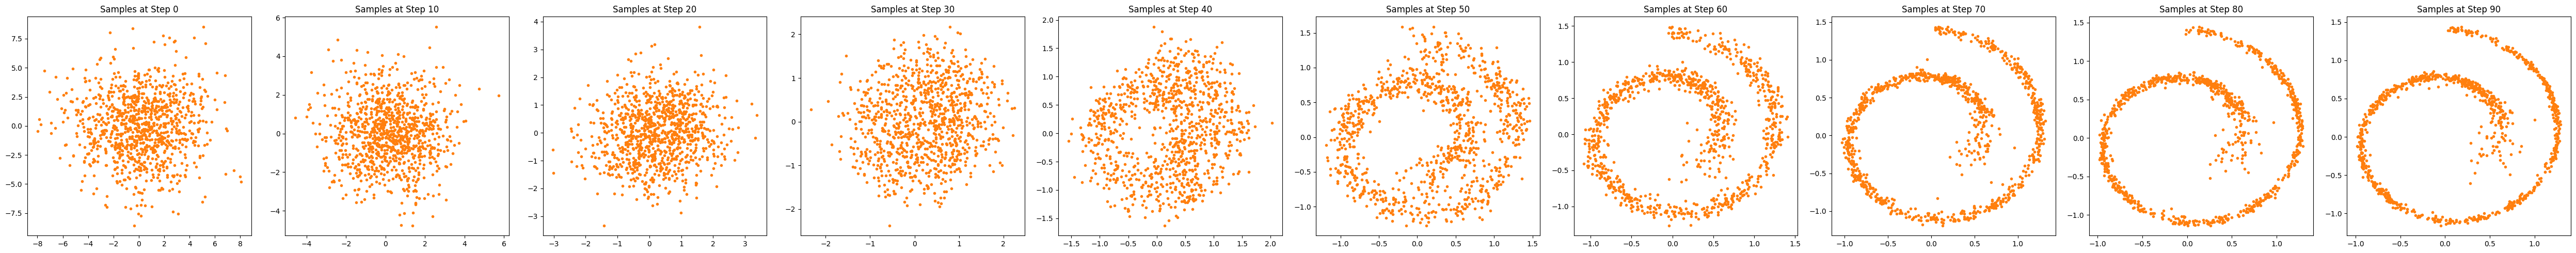

In [20]:
num_plots = len(saved_samples)
fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

for idx, samples in enumerate(saved_samples):
    axs[idx].plot(samples[:, 0], samples[:, 1], 'C1.')
    axs[idx].set_title(f"Samples at Step {idx * 10}")

fig.tight_layout()
plt.show()